# Recommendations with IBM

In this project I have analyzed the interactions that users have with articles on the IBM Watson Studio platform, and have made recommendations to them about new articles we think they will like. This notebook includes parts as follows:


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

First, we explore the data sets. We have two csv files: _user-item-interactions.csv_ and _articles_community.csv_. The former include users (indicated by their emails) and the article id and article titles that each of them had interacted with. The latter, on the othar hand has the detailed information (such as the document body or body text, description, etc) regarding each of the articles on the IBM. 

Then we move on to ranked-based recommendaion, which can be considered as the first stepping stone towards building a recommendation engine. Results of such recommendation can be used for any user including the new users that have no history of interaction on the platform to be used for a more personalised recommendation

A user-user based collaboraborative filtering works on finding the most similar (cosine similarity) users and recommending their highest-interacted articles that are not read by our user. 

The matrix factorization uses SVD for recommendation. To test how this recommendation system works we separated our data to two sets: training and testing datasets. The U, S, and V matrices are then computed using the training set and are used for prediction on testing dataset. As this resommendation system cannot be used for new users, we first separate the common users between the testing and training datasets and then make the recommendation for those users in the testing dataset who also exist in the training dataset. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [4]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

**a. look at articles distribution** 

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: article_id, dtype: int64


Text(0,0.5,'Count')

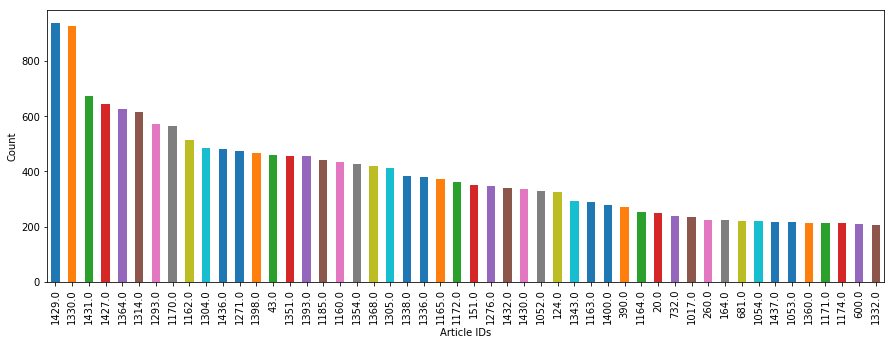

In [5]:
# Count the number of occurance (frequency of reference to) an article amongst different users:
article_frequence = df['article_id'].value_counts()
print(article_frequence.head())
# plot the popularity of the 50 first frequent articles
plt.rcParams['figure.figsize'] = [15, 5]
article_frequence.head(50).plot(kind='bar')
plt.xlabel('Article IDs')
plt.ylabel('Count')

As the bar plot and the printed values of the head() of the dataframe values show, article_id = 1429 has attracted the highest interest among users with the value of 937 number of interactions with it. 

Text(0,0.5,'Count')

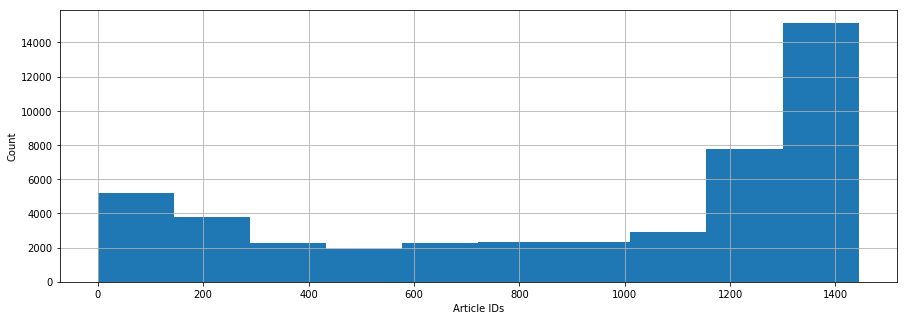

In [6]:
# Here we also plot the histogram of the article IDs to see how the popularity is distributed amongst different articles
df['article_id'].hist()
plt.xlabel('Article IDs')
plt.ylabel('Count')

Although it was not expected, the histogram plot represent a sort of a trend in our article id values and the user interaction. It seems that articles with higher ID has been more popular. This can be either because the ID allocation system to articles is based on article category or topic, meaning that for example articles with 1300<ID<1429 have something in common that attract more people to them. Or the IDing system is based on the time when the article has come out, meaning that articles with higher ID are the most recent articles and due to this fact interaction with them is more.  

In [7]:
# print some statitic description of the columns in df
df.astype({'article_id': 'str'}).describe()

,article_id,title,email
count,45993,45993,45976
unique,714,714,5148
top,1429.0,use deep learning for image classification,2b6c0f514c2f2b04ad3c4583407dccd0810469ee
freq,937,937,364


from the table above we can see that we have 714 unique articles (titles) and 5148 unique users. The most frequent articles is article_ID=1429 with the title of "use deep learning for image classification", which has been interacted with 937 times. There is also one user that has the most interaction (364 times) with the platform's articles. 

The graphas and statistics above are useful but to get more detailed infromation, for example the mean/median/etc values of the distribution I did as follows:

In [8]:
# Here I grouped articles and counted the number of users interacted 
# with each article so can do numerical statistic on the count 
df.groupby(['article_id'])['email'].value_counts()
count_userArticle_interact = df.groupby(['article_id'])['email'].count()
print(count_userArticle_interact.sort_values(ascending=False).head())

# print statistical values for the counted number of users for each article
count_userArticle_interact.describe()

article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: email, dtype: int64


count    714.000000
mean      64.392157
std      109.161462
min        1.000000
25%        8.000000
50%       25.000000
75%       69.000000
max      937.000000
Name: email, dtype: float64

So as the statistic report says, we have 714 unique articles (article_id). The average of article-user interaction (number of users interacting with a specific article) is about 64 users with a big std of about 109 users (as we saw before, it is not a normally distributed case, instead it is a right-skewed distribution as the statistics show as well: median<mean<mode). A huge number of articles (75% of the articles) are Only viewed/used/interacted by 69 times, while a great users' interest lies on only 25% of the articles (The maximum interaction is when 937 users have read/used a specific article). 

**b. look at users distribution**

In [9]:
# Fill in the median and maximum number of user_article interactions below

# To find the median and maximum number of user_article interactions I group the data 
# by user (email) and count the number of articles each user has interacted with.
count_ArticlePerUser = df.groupby(['email'])['article_id'].count() #.nunique() #
print(count_ArticlePerUser.sort_values(ascending=False).head())

# print statistical values for the counted number of article for each user
print(count_ArticlePerUser.describe())
median_val =  count_ArticlePerUser.describe()['50%'] # 50% of individuals interact with ____ number of articles or fewer.
print('50% of individuals interact with {} number of articles or fewer'.format(median_val))
max_views_by_user = count_ArticlePerUser.describe()['max']# The maximum number of user-article interactions by any 1 user is ______.
print('The maximum number of user-article interactions by any 1 user is {} '.format(max_views_by_user))

email
2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
Name: article_id, dtype: int64
count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64
50% of individuals interact with 3.0 number of articles or fewer
The maximum number of user-article interactions by any 1 user is 364.0 


So as the statistic report says, we have 5148 unique users (count). The average (mean) of user-article interaction (number of articles interacted with by a specific user) is about 8-9 articles per person with a std of about 16-17 articles (again it is not a normally distributed case, instead it is a right-skewed distribution as the statistics show as well: median<mean<mode). 75% of the users only viewed/used/interacted 9 times with articles, while the rest of 25% of users have higher interactions with the articles (The maximum interaction is a user with 364 times interactions with different articles).

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [10]:
# Find and explore duplicate articles

# Find duplicated rows in the whole dataset:
print('the total number of duplicates before looking into article_id subset is {}:'.format(df_content[df_content.duplicated()].shape[0]))

# Find duplicated cases in column: "article_id"
df_content[df_content.duplicated(subset=['article_id'], keep=False)].sort_values(by=['article_id']) #

the total number of duplicates before looking into article_id subset is 0:


,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


Looking into the whole dataframe we could not find any 2 same rows. However, when we look at the "articles_id" column I found duplicated articles. Therefore, I listed all the duplicated articles including the first time of occurance to compare them and investigate the reason of similarity/difference. For example, it seems that for article_id=232 the difference roots in "doc_body" but with a closer look, it seems that only the begining of the 'doc_body' is different, which is a part that does not convey any inportant information as it is not part of the actual article main text. Therefore, for this case we can remove the duplicate. On the other hand, for the rticle_id=50, the difference between these two rows lies in both the "description" and in "doc_body". Looking into the document body of both of these cases we can see that these are two different articles, one has a tite "GRAPH-BASED MACHINE LEARNING: PART I" while the other's is "GRAPH-BASED MACHINE LEARNING: PART 2".

In [11]:
pd.set_option('display.max_colwidth', -1)
print(df_content[df_content['article_id']==50]['doc_body'])

50     Follow Sign in / Sign up Home About Insight Data Science Data Engineering Health Data AI Never miss a story from Insight Data , when you sign up for Medium. Learn more Never miss a story from Insight Data Get updates Get updates Sebastien Dery Blocked Unblock Follow Following I don’t know what I’m doing; but then neither do you so it’s all good. Master\r\nof Layers, Protector of the Graph, Wielder of Knowledge. #OpenScience Oct 16\r\n--------------------------------------------------------------------------------\r\n\r\nGRAPH-BASED MACHINE LEARNING: PART I\r\nCOMMUNITY DETECTION AT SCALE\r\nDuring the seven-week Insight Data Engineering Fellows Program recent grads and experienced software engineers learn the latest open source technologies by building a data platform to handle large, real-time datasets.\r\n\r\nSebastien Dery (now a Data Science Engineer at Yewno ) discusses his project on community detection on large datasets.\r\n\r\n\r\n----------------------------------------

For the purpose of this project and due to the fact that we do not know how the assigning of article_id has happened in the IBM system it is best to remove the duplicates from the dataset. However, for the content-based recommendation part, where NLP is going to be used, it might be a good idea to merge cases that has the same article_id but not the same body/text. 

In [12]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset=['article_id'])
print(df_content.duplicated(subset=['article_id']).sum())

0


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [13]:
# checking if there is any null value in the users (Email) cause in that case we cannot relate the article to any actual user and so nee dto be dropped
print("number of unknow users is {}".format(df['email'].isnull().sum()) )
#The number of unique users in the dataset. (excluding null values)
print("number of unique users (excluding null values) is {}".format(df[~df['email'].isnull()]['email'].nunique()) )
# Therefore we can find articles that have actual users connected to them and count the number of unique cases:
print("The number of unique articles that have an interaction with a user is {}".format(df[~df['email'].isnull()]['article_id'].nunique()))
# unique articles in the dataset (whether they have any interactions or not):
print("The number of unique articles in the dataset (whether they have any interactions or not) is {}".format(df_content['article_id'].nunique()))
# The number of user-article interactions in the dataset: 
print("The number of user-article interactions without nans is {}".format(sum(df[~df['email'].isnull()].groupby(['email'])['article_id'].count().tolist())))#sort_values(ascending=False).head())
print("The number of user-article interactions is {}".format(df.shape[0]))


number of unknow users is 17
number of unique users (excluding null values) is 5148
The number of unique articles that have an interaction with a user is 714
The number of unique articles in the dataset (whether they have any interactions or not) is 1051
The number of user-article interactions without nans is 45976
The number of user-article interactions is 45993


In [14]:
unique_articles = df[~df['email'].isnull()]['article_id'].nunique()# The number of unique articles that have at least one interaction
total_articles = df_content['article_id'].nunique()# The number of unique articles on the IBM platform
unique_users = df[~df['email'].isnull()]['email'].nunique()# The number of unique users
user_article_interactions = df.shape[0]# The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [15]:
most_viewed_article_id = str(df['article_id'].value_counts().idxmax())# The most viewed article in the dataset as a string with one value following the decimal 
max_views = df['article_id'].value_counts().max()# The most viewed article in the dataset was viewed how many times?

In [16]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier data analysis and experimentation",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [17]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Here we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` The function below returns the **n** top articles ordered with most interactions as the top. Will test the function using the tests below.

In [18]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Here we first group the dataframe by "title" and then count the number of users
    # we will sort them from the highest rating/interacts and only keep the n largest one
    top_articles = df.groupby(['title'])['user_id'].count() \
    .sort_values(ascending=False).nlargest(n).reset_index()['title'].tolist()
    
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids 
    
    '''
    # Here we first group the dataframe by "article_id" and then count the number of users
    # we will sort them from the highest rating/interacts and only keep the n largest one
    top_articles = df.groupby(['article_id'])['user_id'].count() \
    .sort_values(ascending=False).nlargest(n).reset_index()['article_id'].tolist()
    return list(map(str, top_articles))  # Return the top article ids

In [19]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [20]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` We use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then we place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then we place a zero where the user-row meets for that article-column**. 

At the end we use the tests to make sure the basic structure of the matrix matches what is expected by the solution.

In [21]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item_df = df.groupby(['user_id', 'article_id'])['title'].count().unstack().fillna(0)#.reset_index('user_id')
    user_item_df[user_item_df > 1] = 1
    user_item = user_item_df #np.matrix(user_item_df)
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [22]:
user_item.head() #look at the user-item matrix to make sure that everything has worked correctly
#user_item.sum(axis=1)
#user_item.sum(axis=1)[1]

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` The function below takes a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Then we will use the tests to test the function.

In [24]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    user_item_mat = np.matrix(user_item)
    # compute similarity of each user to the provided user
    user_vec = user_item.loc[user_id]
    user_user_similarities = user_vec.dot(np.transpose(user_item_mat))
    
    # sort by similarity
    sorted_similarities = np.sort(user_user_similarities)[::-1] # sort function sorts everything from lowet to highest.
                                                                # but we want the highest values first so we used [::-1]
    
    # create list of just the ids
    similar_ids_index = user_user_similarities.argsort()[::-1] # here wefind and sort the similarities and get the index(argument)
                                                               # where each appeared in similarity vector
    similar_ids = user_item.iloc[similar_ids_index].index.values # using iloc and the row index location that we found above we
                                                                 # will find the user_ids
    #print(similar_ids)
    
    # remove the own user's id
    most_similar_users = [val for val in similar_ids if val!=user_id]
    #print(np.array(most_similar_users))
    
    return most_similar_users # return a list of the users in order from most to least similar
        

In [25]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that we have a function that provides the most similar users to each user, we will want to use these users to find articles to recommend.  The functions below return the articles we would recommend to each user. 

In [26]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Here first I keep the unique article_ID and title in the dataframe and used the new
    # dataframe to find the article "title" associated with each article_id
    df = df[['article_id','title']].drop_duplicates()
    article_names = list(df[df['article_id'].isin(article_ids)]['title'])
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    user_vec = user_item.loc[user_id] # separate the row belonging to our user from the user-item matrix
    Non_zro_user_vec = user_vec[user_vec!=0] # remove zeros (columns/articles with no interaction) from the vector
    article_ids = Non_zro_user_vec.index.values.astype('str').tolist() # find the artile_ids that our user interected with
    
    article_names = get_article_names(article_ids) #df_content[df_content['article_id'].isin(article_ids)]['doc_full_name']  #get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # find articles read by the user
    User_article_ids, _ = get_user_articles(user_id) 
    
    #find close users
    similar_users = find_similar_users(user_id)
    recs = []
    for sim_user in similar_users:
        rec_article_ids, _ = get_user_articles(sim_user)
        recs.extend([i for i in rec_article_ids if i not in User_article_ids])
        if len(recs)>=m:
            recs = recs[:m]
            break
    
    return recs # return your recommendations for this user_id    

In [27]:
get_user_articles(20, user_item)

(['232.0', '844.0', '1320.0'],
 ['housing (2015): united states demographic measures',
  'use the cloudant-spark connector in python notebook',
  'self-service data preparation with ibm data refinery'])

In [28]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'timeseries data analysis of iot events by using jupyter notebook',
 'graph-based machine learning',
 'using brunel in ipython/jupyter notebooks',
 'experience iot with coursera',
 'the 3 kinds of context: machine learning and the art of the frame',
 'deep forest: towards an alternative to deep neural networks',
 'this week in data science (april 18, 2017)',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty']

In [29]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [30]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Fiding neighboring Id or the most similar users:
    Neighbor_ids = find_similar_users(user_id, user_item)
    
    user_item_mat = np.matrix(user_item) # turn dataframe to matrix form
    # compute similarity of each user to the provided user
    user_vec = user_item.loc[user_id]
    user_user_similarities = user_vec.dot(np.transpose(user_item_mat))
    # sort by similarity
    sorted_similarities = np.sort(user_user_similarities)[::-1]
    # remove the similarity of the input-user to itself
    similarities = [val for val in sorted_similarities if val!=np.sum(user_vec)]
    
    # counting the number of articles viewed by neighbouring users 
    num_interactions = [df[df['user_id']==Uid]['article_id'].count() for Uid in Neighbor_ids]
    
    # put all computed parameters into a dataframe:
    neighbors_df = pd.DataFrame()
    neighbors_df['neighbor_id'] = Neighbor_ids
    neighbors_df['similarity'] = similarities
    neighbors_df['num_interactions'] = num_interactions
    
    # sort the neighbors_df by the similarity and then by number of interaction
    neighbors_df.sort_values(['similarity', 'num_interactions'])
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # find articles resd by the user
    User_article_ids, _ = get_user_articles(user_id)
    
    # articles' interatctions sorted from highest to lowest
    articles_interact = df.groupby(['article_id'])['user_id'].count().sort_values(ascending=False)
    #print(articles_interact)
    article_interact_id = [articles_interact.index[key] for key, _ in enumerate(articles_interact)]
    #print(article_interact_id)
    
    # find close user_ids and loop through them starting with the users with high similarity and highest article interaction/read
    neighbors_df = get_top_sorted_users(user_id)
    
    recs = []
    for U_id in neighbors_df['neighbor_id']:
        rec_article_ids, _ = get_user_articles(U_id)
        recs.extend([i for i in rec_article_ids if i not in User_article_ids]) # finding the articles that closest users have read
        #print(recs)
        recs = [rec for rec in article_interact_id if str(rec) in recs] # sort the articles from closest users in a way 
                                                                        # that the most interacted articles come first
        #print(recs)
        if len(recs)>=m:
            recs = recs[:m]
            break
    
    rec_names = get_article_names(recs) # get the articles name using their IDs
    
    return recs, rec_names

In [31]:
get_top_sorted_users(131)[:12]

,neighbor_id,similarity,num_interactions
0,3870,74.0,144
1,3782,39.0,363
2,23,38.0,364
3,4459,33.0,158
4,203,33.0,160
5,98,29.0,170
6,3764,29.0,169
7,3697,29.0,145
8,49,29.0,147
9,242,25.0,148


In [32]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1162.0, 1304.0, 43.0, 1351.0]

The top 10 recommendations for user 20 are the following article names:
['healthcare python streaming application demo', 'use deep learning for image classification', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'model bike sharing data with spss', 'deep learning with tensorflow course by big data university']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [33]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1)['neighbor_id'].tolist()[0]# Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131)['neighbor_id'].tolist()[9]# Find the 10th most similar user to user 131

In [34]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**The only recommendation we can do to a new user (with no history of activity on the platform) is recommending the top ranked articles using "Rank-Based Recommendations" ("get_top_articles" and "get_top_article_ids" functions).  We cannot make any recommendation based on "User-User Based Collaborative Filtering" for a new user. This is because the functions would look for a user_id within the user-item dataframe/matrix and if the user is not there it will give an error.**

`7.` Using the existing functions, we provide the top 10 recommended articles that would provide for the a new user below.  We test the function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [35]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)

print(new_user_recs)

['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [36]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [38]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, we will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` A **user_item** matrix has already been created above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [37]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [38]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, we use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.

In [39]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices
print(u.shape, s.shape, vt.shape)

(5149, 5149) (714,) (714, 714)


**The SVD works because it does not have nan values (unknown values) and therefore svd works fine without giving any error. Therefore there is no need to use FunkSVD instead**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

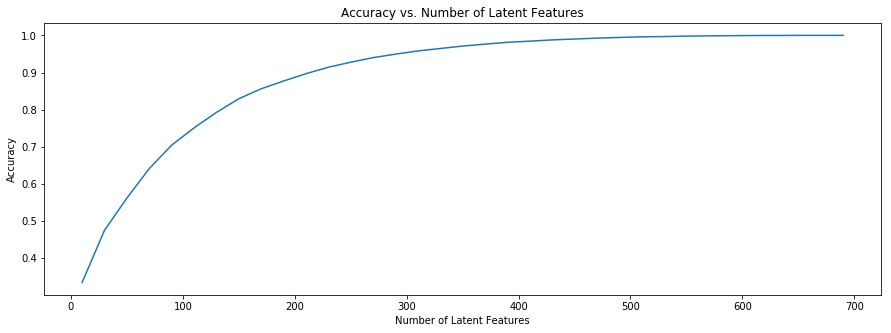

In [40]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [41]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # making user-item matrix for training set:
    user_item_train = create_user_item_matrix(df_train)
        
    # making user-item matrix for testing set:
    user_item_test = create_user_item_matrix(df_test)
    #print(user_item_test.head())
    
    test_idx = user_item_test.index.tolist() #[user_item_test.index[key] for key, _ in enumerate(user_item_test)]
    #print(test_idx)
    test_arts = user_item_test.columns
    #print(test_arts)
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [42]:
train_idx = user_item_train.index.tolist() # finding the user_ids in the training set
print(len(list(np.intersect1d(test_idx, train_idx))) ) # finding the common user_id in both train and test data frames

20


So only 20 of the rows/users from the test dataset exist in the training dataset

In [43]:
train_arts = user_item_test.columns.tolist() # finding the articles in the training set 
print(len(list(np.intersect1d(test_arts, train_arts))) ) # finding the common article_id in both train and test data frames
#print(user_item_test.head())
print(user_item_test.shape)

574
(682, 574)


So all the columns in the test dataset exists in the training dataset

In [44]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now using the **user_item_train** dataset from above we find U, S, and V transpose using SVD. Then we will find the subset of rows in the **user_item_test** dataset that we can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

In [45]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below

In [46]:
print(u_train.shape, s_train.shape, vt_train.shape)

(4487, 4487) (714,) (714, 714)


In [47]:
def Find_predictable_RowCols(user_item_train, user_item_test):
    '''
    INPUT:
    user_item_train - user-item traing dataset
    user_item_test - user-item testing dataset
    
    OUTPUT:
    predictable_user_item_test_matrix - a subset of user_item_test that is predictable from the user_item_train
    '''
    # Create series of users and articles (item) in the right order
    train_user_ids_series = np.array(user_item_train.index) # user ids in train dataset
   
    test_user_ids_series = np.array(user_item_test.index) # user ids in test dataset
    cols = np.array(user_item_test.columns) # article ids in the test dataset
    
    # find users ids in test dataset that is also common in train dataset
    predictable_users = list(np.intersect1d(test_user_ids_series, train_user_ids_series)) 
    
    # separating rows of the testing data set that is shared in train dataset and saving them in a new dataframe 
    rows = []
    for i in predictable_users:
        rows.append(user_item_test.loc[i].tolist())
    predictable_user_item_test_matrix = pd.DataFrame(rows, columns=cols)
    
    return predictable_user_item_test_matrix

In [48]:
predictable_user_item_test = Find_predictable_RowCols(user_item_train, user_item_test)
predictable_user_item_test.head()

,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1443.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
def validation_comparison(user_item_train, predictable_user_item_test, u_train, s_train, vt_train, test_arts):
    '''
    INPUT:
    user_item_train - user_item_matrix belonging to the training data set
    predictable_user_item_test - part of the user_item_matrix belonging to the testing 
                                 dataset where the rows/users exist in our training dataset
    u_train - U matrix from SVD on train dataset 
    s_train - V matrix from SVD on train dataset
    vt_train - vector containing eigen values computed from applying SVD on Train dataset
    test_arts - article_ids in test data
        
    OUTPUT:
        Non
        but it computes the total error between predicted and actual values for testing dataset and plots 
        the accuracy against number of latent features to see how many latent features is good to make predictions.
    '''
    num_latent_feats = np.arange(10,700+10,20) # a rang of number of latent features to be used for accuracy testing
    sum_errs_test = []
    sum_errs_train = []

    for k in num_latent_feats:
        # restructure with k latent features
        s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]

        # take dot product
        user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
        
        #separating intersected rows and columns
        rows = []
        for i in np.array(predictable_user_item_test.index): 
            rows.append([user_item_est[i,j] for j in range(len(test_arts))])
        user_item_est_sliced = pd.DataFrame(rows, columns=test_arts)

        # compute error for each prediction to actual value
        diffs_test = np.subtract(predictable_user_item_test, user_item_est_sliced)
        diffs_train = np.subtract(user_item_train, user_item_est)

        # total errors and keep track of them
        err_test = np.sum(np.sum(np.abs(diffs_test)))
        sum_errs_test.append(err_test)
        err_train = np.sum(np.sum(np.abs(diffs_train)))
        sum_errs_train.append(err_train)


    plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(predictable_user_item_test.shape[0]*predictable_user_item_test.shape[1]), label='Test')
    plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(user_item_train.shape[0]*user_item_train.shape[1]), label='Train');
    plt.xlabel('Number of Latent Features');
    plt.ylabel('Accuracy');
    plt.title('Accuracy vs. Number of Latent Features');  
    plt.legend()


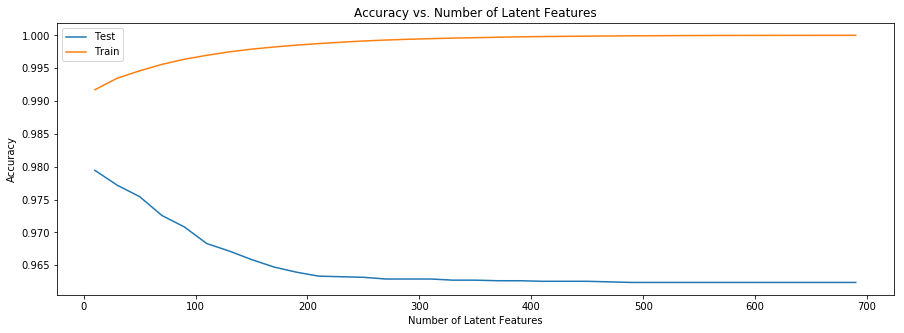

In [59]:
validation_comparison(user_item_train, predictable_user_item_test, u_train, s_train, vt_train, test_arts)

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**The accuracy decreases as we increase the number of latent features for predicting the test dataset. This behaviour can be because we are only using 20 rows and 574 columns of the trained svd matrix to predict the test dataset, which means we do not have enough data to test how good our predictions are. Increasing the number of latent features (as we can see from the orange line belonging to accuracy of predicting train dataset) overfits the training data which means it underfits the test data, therefore the accuracy of prediction decreases. The highest accuracy of prediction for test data is when we have less than 10 latent features. If we can increase the number of rows_ID/user_ID in the test data set that are also in the training, then collaborative filtering based recommendation using the Matrix Factorization (SVD) could be considered in our recommendation system. For new users we can use top item (high ranked) recommendations and for existing users a combination of User-User Based Collaborative Filtering and Matrix Factorization (SVD) can be used as the recommendation engin.**

<a id='conclusions'></a>

## Conclusion

> In this notebook, I analyzed the data regarding the interactions that users have with articles on the IBM Watson Studio platform. I used three methods of recommendations namely, Ranked-based recommendation, user-user (neighborhood) collaborative filttering, and model-based (Matrix Factorization - SVD) collaborative filtering to recommend new articles we think the users will like. The Ranked-based recommendation is suitable for new users to the platform, whom we do not have any history of interaction with the platform to make a more personalized recommendation. The user-user collaborative filtering works in this way that it finds the most similar users to our candidate and then, among all the articles that the neighbor user has interacted with, we recommend the most interacted articles to our candidate. This method is one step towards making a more personalized recommendation, however it is not suitable for dealing with new users. With the model-based collaborative recommendation we use matrix factorization (SVD in this case), which not only helps us with making a more personalized recommendation (due to the latent featurs that are related to the articles and users) we can measure how well our prediction works by splitting our data to train and test datasets. However, again this method cannot handle new users, therefore our evaluation is restricted to users and articles that are shared between train and test datasets. To deal with new users (cold start), my suggestions would be using the ranked based technique and/or a combination of knowledge-based (not implemented here) + content-based (not implemented here) + ranked-based recommendations.


## Convert to html

> To create a .html or .pdf version of this notebook in the workspace, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory.


In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])